In [114]:
# rl-stats-eda notebook
# Import statements
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import json
import scraper as s
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError
%matplotlib inline
#plt.style.use('ggplot')

# Define MongoDB database and collection
db_client = MongoClient('localhost', 27017)
db = db_client['rocket_league']
rl_replays = db['rl_replays']

In [115]:
s.ping_api()

200

### MongoDB Testing

In [12]:
"""
Currently doing in memory, but would like to send data to collection
**FOR ONE ENTRY IN NEW COLLECTION**
GAME STATS:
replay_id

PLAYER STATS (initialized with mongo):
name, car_name, goals, demo_inflicted, demo_taken
 

TEAM STATS (created from PLAYER STATS in pandas):
blue_total_goals, blue_total_demos_inflicted, blue_total_demos_taken
orange_total_goals, orange_total_demos_inflicted, orange_total_demos_taken

"""

'\nCurrently doing in memory, but would like to send data to collection\n**FOR ONE ENTRY IN NEW COLLECTION**\nGAME STATS:\nreplay_id\n\nPLAYER STATS (initialized with mongo):\nname, car_name, goals, demo_inflicted, demo_taken\n \n\nTEAM STATS (created from PLAYER STATS in pandas):\nblue_total_goals, blue_total_demos_inflicted, blue_total_demos_taken\norange_total_goals, orange_total_demos_inflicted, orange_total_demos_taken\n\n'

In [121]:
"""
Get clean data from every replay
"""

df_cols = ["blue_total_goals",
    "blue_total_demos_inflicted",
    "blue_total_demos_taken",
    "orange_total_goals",
    "orange_total_demos_inflicted",
    "orange_total_demos_taken"]

r_data = np.zeros((db.rl_replays.count(), len(df_cols)))

r_id = []


print(r_data.shape)
len(r_id)

(2838, 6)


0

In [122]:
# get relevant info from database
replay_cursor = db.rl_replays.find({}, 
    {"_id":1,
    "blue":1,
    "orange":1})


In [123]:
bad_data_row_nums = []

for row,replay in enumerate(replay_cursor):
    try:
        r_id.append(str(replay['_id']))
        # Get info for Blue Team
        for player in replay["blue"]["players"]:
            r_data[row][0] += player["stats"]["core"]["goals"]
            r_data[row][1] += player["stats"]["demo"]["inflicted"]
            r_data[row][2] += player["stats"]["demo"]["taken"]
        # Get info for Orange Team
        for player in replay["orange"]["players"]:
            r_data[row][3] += player["stats"]["core"]["goals"]
            r_data[row][4] += player["stats"]["demo"]["inflicted"]
            r_data[row][5] += player["stats"]["demo"]["taken"]
    except:
        bad_data_row_nums.append(row)    # save bad rows for dropping later

print(len(bad_data_row_nums))


1583


In [124]:
# quick entry/format check
print(f'first 5 of r_data.  Total length = {len(r_data)}')
print(r_data[:5])
print(f'\nfirst 5 of r_id.  Total length = {len(r_id)}')
print(r_id[:5])
print(f'\nfirst 5 of bad_data_row_nums.  Total length = {len(bad_data_row_nums)}')
print(bad_data_row_nums[:5])

first 5 of r_data.  Total length = 2838
[[4. 1. 4. 3. 4. 1.]
 [0. 1. 1. 5. 1. 1.]
 [7. 0. 0. 4. 0. 0.]
 [1. 1. 1. 2. 1. 1.]
 [2. 1. 6. 1. 6. 1.]]

first 5 of r_id.  Total length = 2838
['5f99c559d3221fc02865826b', '5f99c55ad3221fc02865826c', '5f99c55ad3221fc02865826d', '5f99c55bd3221fc02865826e', '5f99c55bd3221fc02865826f']

first 5 of bad_data_row_nums.  Total length = 1583
[18, 20, 22, 24, 26]


In [125]:
#df = pd.DataFrame(r_data, columns=df_cols, index=r_id)
df = pd.DataFrame(r_data, columns=df_cols)
df = df.drop(bad_data_row_nums)    # dropping rows that threw exception
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 2825
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blue_total_goals              1255 non-null   float64
 1   blue_total_demos_inflicted    1255 non-null   float64
 2   blue_total_demos_taken        1255 non-null   float64
 3   orange_total_goals            1255 non-null   float64
 4   orange_total_demos_inflicted  1255 non-null   float64
 5   orange_total_demos_taken      1255 non-null   float64
dtypes: float64(6)
memory usage: 68.6 KB


<AxesSubplot:>

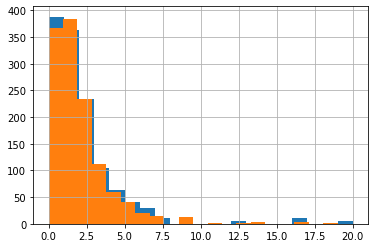

In [132]:
# TODO: Add key
df['blue_total_demos_inflicted'].hist(bins=20)
df['orange_total_demos_inflicted'].hist(bins=20)

In [133]:
df.describe()

,blue_total_goals,blue_total_demos_inflicted,blue_total_demos_taken,orange_total_goals,orange_total_demos_inflicted,orange_total_demos_taken
count,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000
mean,2.601594,1.749004,1.667729,2.627092,1.705976,1.787251
std,1.914187,2.479893,2.144769,1.785436,2.165134,2.509026
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
75%,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000
max,16.000000,20.000000,19.000000,10.000000,19.000000,20.000000


In [136]:
print(df['blue_total_demos_inflicted'].value_counts())
df['orange_total_demos_inflicted'].value_counts()

0.0     388
1.0     363
2.0     234
3.0     105
4.0      63
5.0      40
6.0      30
7.0      11
16.0     10
20.0      6
12.0      5
Name: blue_total_demos_inflicted, dtype: int64


1.0     384
0.0     367
2.0     234
3.0     112
4.0      59
5.0      40
6.0      20
7.0      14
9.0      12
14.0      4
17.0      4
11.0      2
13.0      2
19.0      1
Name: orange_total_demos_inflicted, dtype: int64

In [147]:
# Get combined goals and demos - team does not matter
all_demos_inflicted = df['blue_total_demos_inflicted'] + df['orange_total_demos_inflicted']
all_goals_scored = df['blue_total_goals'] + df['orange_total_goals']

print(f'Total Demos = {all_demos_inflicted}\n')
print(f'Total Goals = {all_goals_scored}')

Total Demos = 0       5.0
1       2.0
2       0.0
3       2.0
4       7.0
       ... 
2763    4.0
2779    4.0
2795    5.0
2810    1.0
2825    3.0
Length: 1255, dtype: float64

Total Goals = 0        7.0
1        5.0
2       11.0
3        3.0
4        3.0
        ... 
2763     9.0
2779     5.0
2795     3.0
2810     7.0
2825     4.0
Length: 1255, dtype: float64


In [ ]:
# Plot demos vs goals


In [113]:
def welch_test_statistic(sample_1, sample_2):
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + \
                        (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)

In [ ]:
# Testing
# demo_bot_25, demo_top_25 -> Series
# test_stat = welch_test_statistic(demo_bot_25, demo_top_25)
# t-stats, p_value = stats.ttest_ind(demo_bot_25, demo_top_25, equal_var=False)

In [148]:
"""
H0: mean goals scored for top 25% of demos is greater than mean goals scored for bottom 25% of demos
HA: Mean goals scored for bottom 25% of demos is greater than mean goals scored for top 25% of demos
"""

'\nH0: mean goals scored for top 25% of demos is greater than mean goals scored for bottom 25% of demos\nHA: Mean goals scored for bottom 25% of demos is greater than mean goals scored for top 25% of demos\n'